BASED ON https://github.com/bnsreenu/python_for_microscopists/blob/master/216_mito_unet__xferlearn_12_training_images.py

In [6]:
import tensorflow as tf

In [2]:
import keras
keras.__version__

'2.13.1'

In [8]:
import numpy as np
from matplotlib import pyplot as plt 
from patchify import patchify
import tifffile as tiff

In [11]:
# Reads tiff image stack files
# Replace with appropriate image path
nucleus_image_stack = tiff.imread('/Users/katyaluchette/Downloads/image_stack_for_nucleus_final.tif')
nucleus_mask_stack = tiff.imread('/Users/katyaluchette/Downloads/label_stack_for_nucleus_final.tif')

In [12]:
# Check the shape of the stack (make sure that it is the same size as your stack)
print(nucleus_image_stack.shape)

(44, 2560, 2160)


In [13]:
import cv2

In [14]:
# Need to resize each image to be square for the model to process the image
# Pick square dimension closest to the actual dimension of the image that is a multiple of 12 
size = (2048, 2048)

# Here will patchify the images
# Choose an appropriate patchify size (smaller for more detailed segmentations)
# If the patchify is too small, the model will struggle to produce accurate predictions

all_img_patches = []
# iterates over all images in the image stack
for img in range(nucleus_image_stack.shape[0]):
    large_image = nucleus_image_stack[img]
    # Resize each image
    large_image = cv2.resize(large_image, size)
    # Patchify each image, to change patchify size modify (512, 512) to be something else
    # Step should be the same size as what the patchify value is
    patches_img = patchify(large_image, (512, 512), step=512)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            all_img_patches.append(single_patch_img)
    
    images = np.array(all_img_patches)
    images = np.stack((images,)*3, axis=-1)

    all_mask_patches = []
    # iterates over all images in the mask stack
    for img in range(nucleus_mask_stack.shape[0]):
        large_mask = nucleus_mask_stack[img]
        # resize each mask
        large_mask = cv2.resize(large_mask, size)
        # patchify each mask, the patchify size SHOULD be the same as the one chosen above
        patches_mask = patchify(large_mask, (512, 512), step=512)

        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[i,j,:,:]

                # divide by whatever color value you chose to annotate with in Napari
                single_patch_mask = single_patch_mask / 12.

                all_mask_patches.append(single_patch_mask)


    masks = np.array(all_mask_patches)
    masks = np.expand_dims(masks, -1)

In [16]:
# Ensure that the size of the image and mask stacks is (size / patchify size) * (size / patchify size) * size of stack
print(images.shape)
print(masks.shape)

(704, 512, 512, 3)
(704, 512, 512, 1)
Pixel values in the mask are:  [0.00000000e+00 4.88281250e-04 1.46484375e-03 2.44140625e-03
 3.41796875e-03 3.90625000e-03 4.39453125e-03 5.37109375e-03
 6.34765625e-03 7.32421875e-03 8.30078125e-03 9.27734375e-03
 1.02539062e-02 1.12304688e-02 1.17187500e-02 1.22070312e-02
 1.31835938e-02 1.41601562e-02 1.51367188e-02 1.61132812e-02
 1.70898438e-02 1.80664062e-02 1.90429688e-02 1.95312500e-02
 2.00195312e-02 2.09960938e-02 2.19726562e-02 2.29492188e-02
 2.39257812e-02 2.49023438e-02 2.58789062e-02 2.68554688e-02
 2.73437500e-02 2.78320312e-02 2.88085938e-02 2.97851562e-02
 3.07617188e-02 3.17382812e-02 3.27148438e-02 3.36914062e-02
 3.46679688e-02 3.51562500e-02 3.56445312e-02 3.66210938e-02
 3.75976562e-02 3.85742188e-02 3.95507812e-02 4.05273438e-02
 4.15039062e-02 4.24804688e-02 4.29687500e-02 4.34570312e-02
 4.44335938e-02 4.54101562e-02 4.63867188e-02 4.73632812e-02
 4.83398438e-02 4.93164062e-02 5.02929688e-02 5.07812500e-02
 5.12695312e-02 

In [17]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
# import pretrained model package
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [18]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

images1 = preprocess_input1(images)
print(images1.shape)

(704, 512, 512, 3)


In [19]:
from sklearn.model_selection import train_test_split
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(images1, masks, test_size = 0.25, random_state = 42)
# ensure that the shape of each stack is correct
print(X_train.shape)
print(X_test.shape)

(528, 512, 512, 3)
(176, 512, 512, 3)


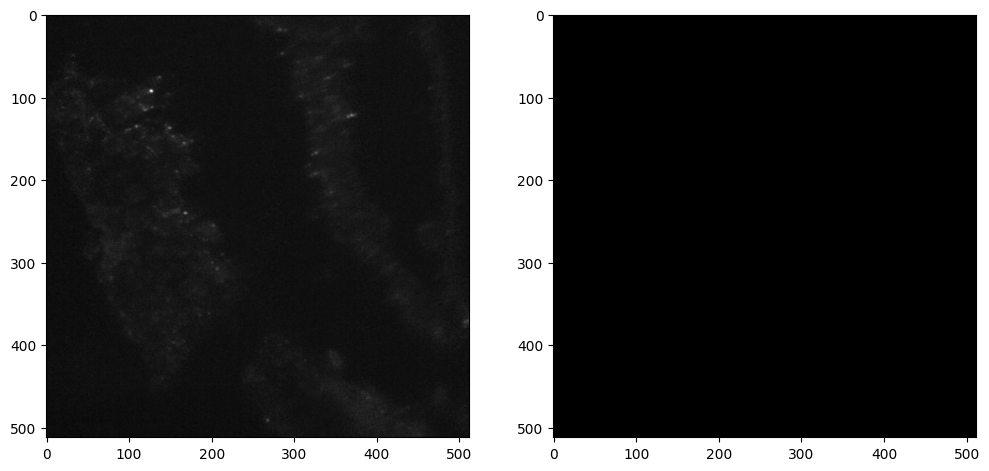

In [16]:
#sanity check: check to make sure images and masks align
import random
import numpy as np
image_number = random.randint(0, len(X_train) - 1)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_train[image_number, :, :, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (512, 512)), cmap='gray')
plt.show()

In [17]:
#augmentation for images and masks
seed = 24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                         width_shift_range=0.3,
                         height_shift_range=0.3,
                         shear_range=0.5,
                         zoom_range=0.3,
                         horizontal_flip = True,
                         vertical_flip=True,
                         fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                          width_shift_range=0.3,
                          height_shift_range=0.3,
                          shear_range=0.5,
                          zoom_range=0.3,
                          horizontal_flip=True,
                          vertical_flip=True,
                          fill_mode='reflect',
                          preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment = True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)


def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

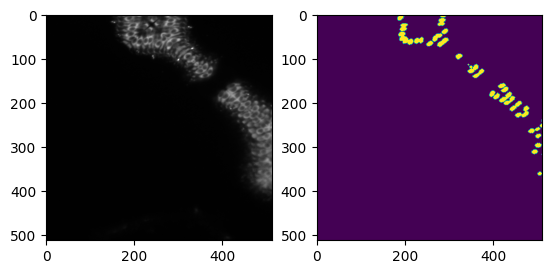

In [18]:
#ensure that that masks align with the image after augmentation
x = image_generator.next()
y = mask_generator.next()

for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [19]:
#load model
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
model = sm.Unet(BACKBONE, encoder_weights = 'imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

In [20]:
#train model
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=40, validation_steps=40, epochs=40, batch_size = 32)

Epoch 1/40
40/40 [==============================] - 1220s 30s/step - loss: 1.3388 - iou_score: 0.0037 - val_loss: 72.4617 - val_iou_score: 0.0025
Epoch 2/40
40/40 [==============================] - 1193s 30s/step - loss: 1.0599 - iou_score: 0.0156 - val_loss: 1.0602 - val_iou_score: 0.0020
Epoch 3/40
40/40 [==============================] - 1172s 29s/step - loss: 0.9761 - iou_score: 0.0546 - val_loss: 1.2753 - val_iou_score: 0.0023
Epoch 4/40
40/40 [==============================] - 1186s 30s/step - loss: 0.8482 - iou_score: 0.1661 - val_loss: 1.0321 - val_iou_score: 0.0012
Epoch 5/40
40/40 [==============================] - 1185s 30s/step - loss: 0.6603 - iou_score: 0.3500 - val_loss: 147.9304 - val_iou_score: 0.0018
Epoch 6/40
40/40 [==============================] - 1167s 29s/step - loss: 0.5719 - iou_score: 0.4395 - val_loss: 1.0181 - val_iou_score: 2.5314e-04
Epoch 7/40
40/40 [==============================] - 1197s 30s/step - loss: 0.5542 - iou_score: 0.4535 - val_loss: 1.0224 - 

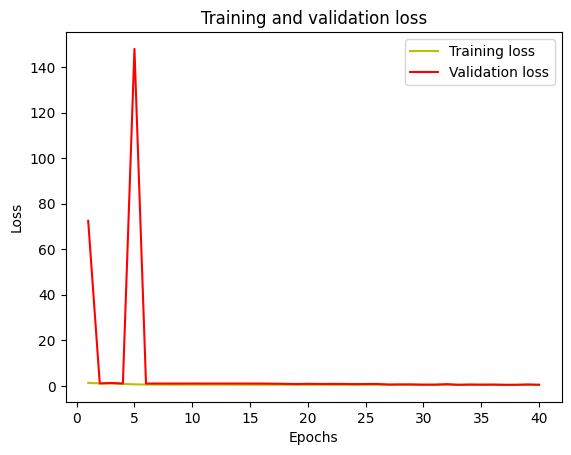

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

In [22]:
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)

6/6 [==============================] - 33s 5s/step
IoU score is:  0.5571030085674438


1/1 [==============================] - 0s 232ms/step


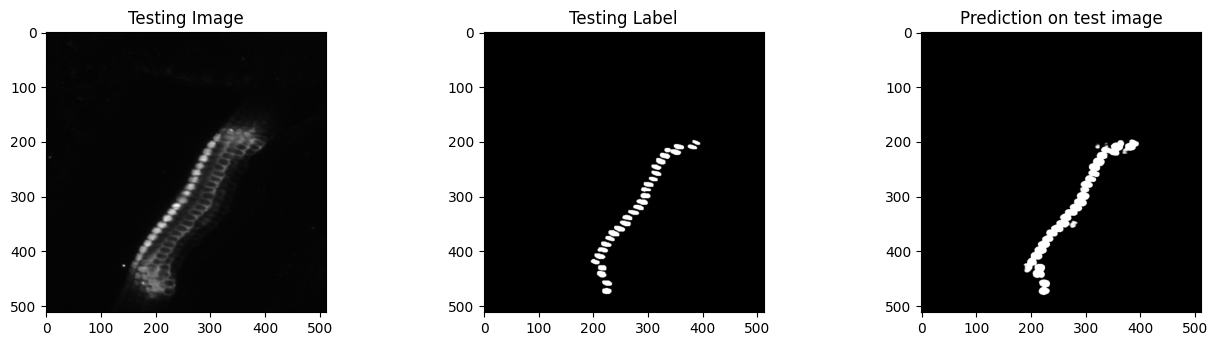

In [197]:
# check to see what predictions are looking like
import random

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
ground_truth = y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction [0,:,:,0]

plt.figure(figsize=(16,8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap = 'gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

In [105]:
#save model (change name to whatever you want to save the model as)
model.save('nucleus_segmentation_final.h5')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 3s 3s/step


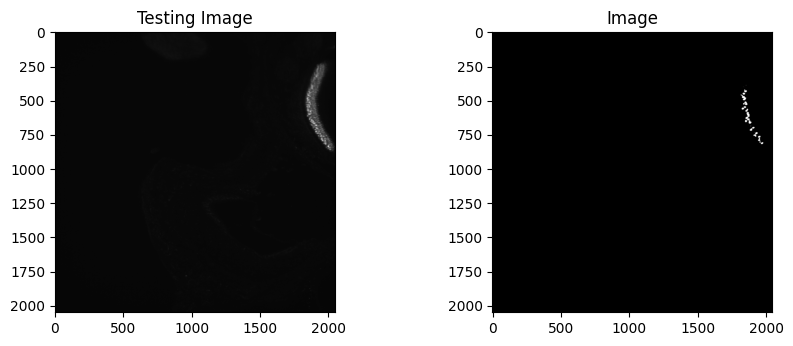

In [132]:
#check to see how model is performing on the test set images
test_img_number_pred = random.randint(0, len(images_pred)-1)
test_img_pred = images_pred[test_img_number_pred]
test_img_input_pred = np.expand_dims(test_img_pred, 0)
prediction_pred = model.predict(test_img_input_pred)
test_img = images_pred[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

check_image = prediction_pred [0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Image')
plt.imshow(check_image, cmap='gray')
plt.show()

